In [7]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
#sklearn
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import learning_curve, ShuffleSplit
from sklearn.metrics import f1_score, make_scorer, accuracy_score, confusion_matrix, classification_report


from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

from xgboost import XGBClassifier
#from catboost import CatBoostClassifier

In [8]:
#Reading the Dataset
df=pd.read_excel('/content/drive/MyDrive/bilayer GelMA study/Bilayer DS data_varying cell quantity.xlsx')
df.head()

,Average Zeroed Cap@174kHz,Average Zeroed Cap@224kHz,Average Zeroed Cap@287kHz,Average Zeroed Cap@368kHz,Average Zeroed Cap@473kHz,Average Zeroed Cap@607kHz,Average Zeroed Cap@779kHz,Average Zeroed Cap@1000kHz,Average Zeroed Cap@1284kHz,Average Zeroed Cap@1648kHz,Average Zeroed Cap@2115kHz,Group,Day
0,1.580,1.560,1.024,0.914,0.790,0.602,0.431,0.289,0.242,0.285,0.262,1.0,1.0
1,1.658,1.659,0.997,0.843,0.720,0.579,0.424,0.348,0.314,0.244,0.194,1.0,1.0
2,1.653,1.505,0.962,1.017,0.935,0.501,0.407,0.337,0.262,0.305,0.208,1.0,1.0
3,1.586,1.642,1.180,0.801,0.690,0.579,0.466,0.349,0.228,0.268,0.173,1.0,1.0
4,1.776,1.453,1.047,1.058,0.997,0.561,0.444,0.267,0.207,0.222,0.218,1.0,1.0


In [9]:
X=df[['Average Zeroed Cap@174kHz', 'Average Zeroed Cap@224kHz', 'Average Zeroed Cap@287kHz', 'Average Zeroed Cap@368kHz', 'Average Zeroed Cap@473kHz', 'Average Zeroed Cap@607kHz', 'Average Zeroed Cap@779kHz', 'Average Zeroed Cap@1000kHz', 'Average Zeroed Cap@1284kHz', 'Average Zeroed Cap@1648kHz', 'Average Zeroed Cap@2115kHz']]
Y=df[['Group','Day']]

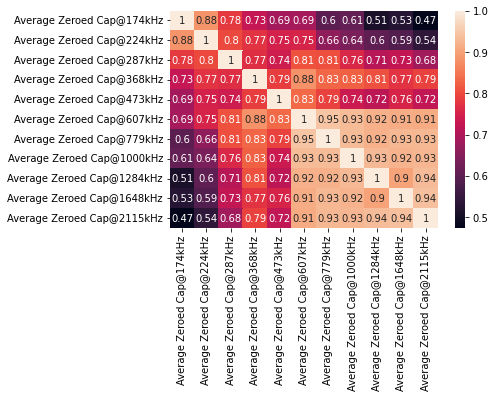

In [10]:
#Heatmap
sns.heatmap(X.corr(), annot=True);

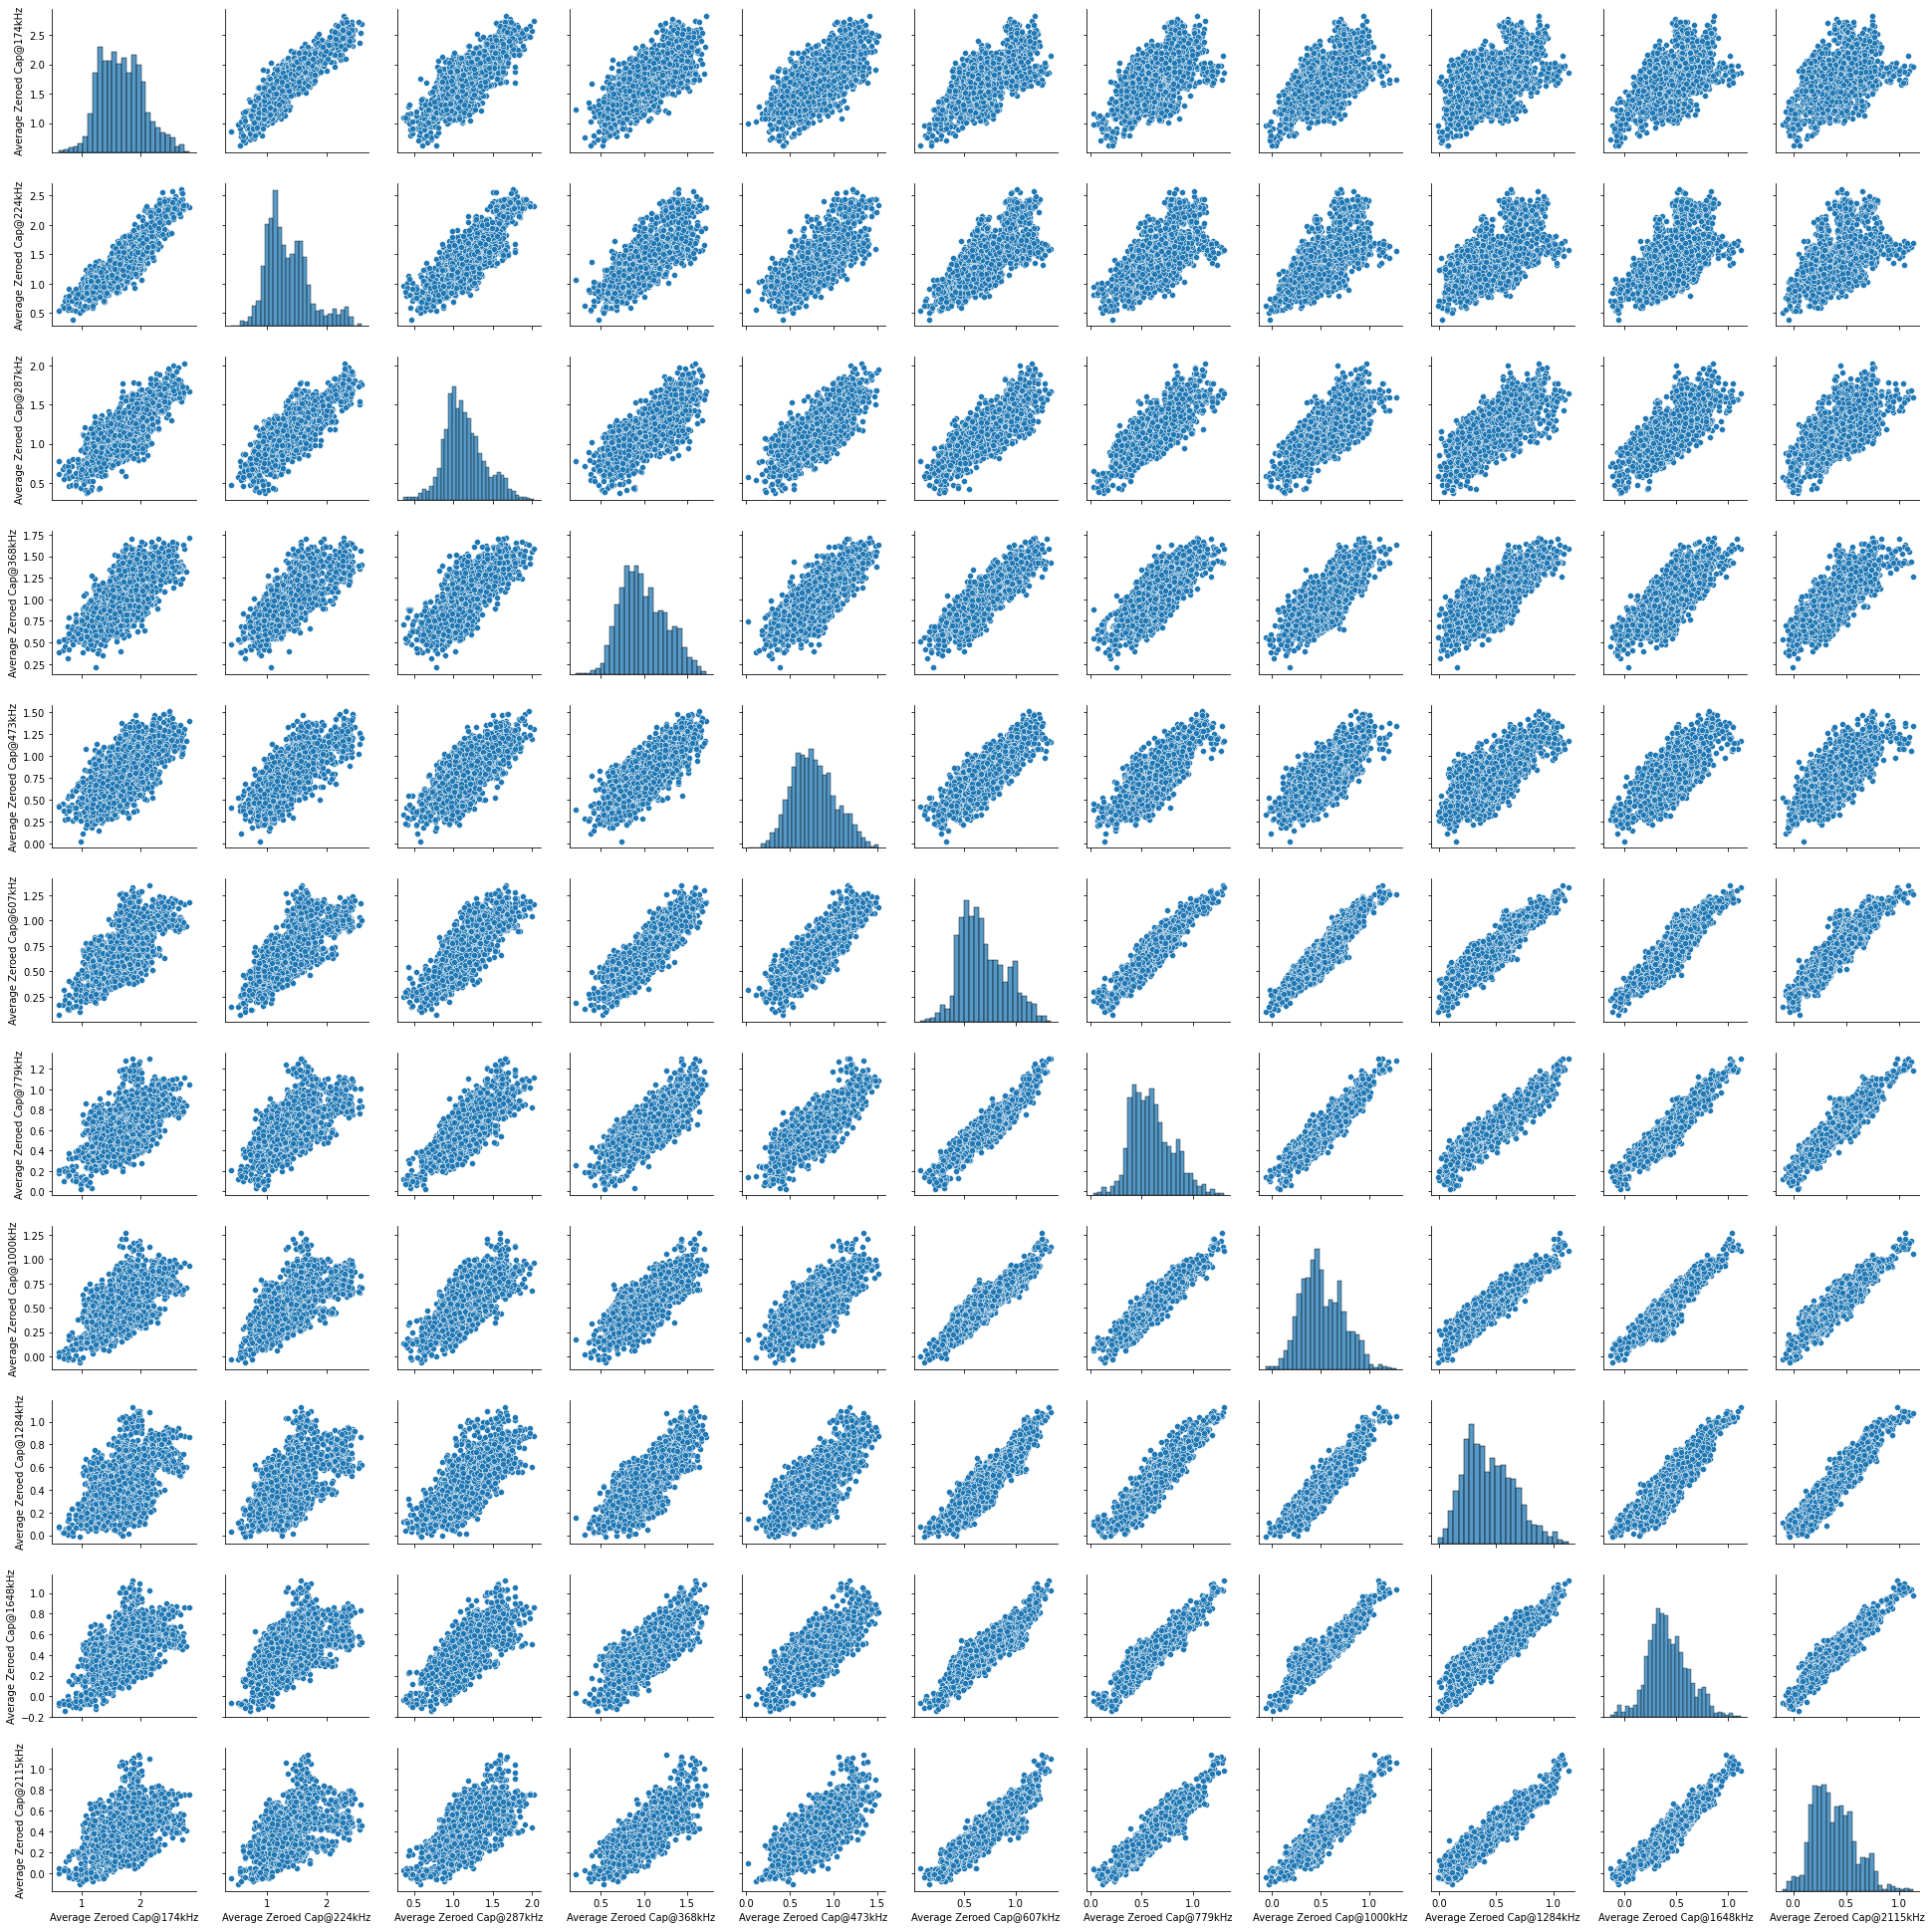

In [6]:
sns.pairplot(X)

In [11]:
# confusion matrix
def print_confusion_matrix(confusion_matrix, class_names, figsize = (6,4), fontsize=14):
    
    df_cm = pd.DataFrame(
        confusion_matrix, index=class_names, columns=class_names,
    )
    fig = plt.figure(figsize=figsize)
    try:
        heatmap = sns.heatmap(df_cm, annot=True, fmt="d", cmap='viridis')
    except ValueError:
        raise ValueError("Confusion matrix values must be integers.")
    heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=fontsize)
    heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45, ha='right', fontsize=fontsize)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [12]:
#Grid search

def grid_search(clf, parameters, scorer, train_data, test_data, cv=5):

    #Perform grid search on the classifier using 'scorer' as the scoring method.
    grid_obj = GridSearchCV(clf, parameters, scoring=scorer)

    # Fit the grid search object to the training data and find the optimal parameters.
    grid_fit = grid_obj.fit(train_data[0], train_data[1])

    # Get the estimator.
    best_clf = grid_fit.best_estimator_

    # Fit the new model.
    best_clf.fit(train_data[0], train_data[1])

    # Make predictions using the new model.
    best_train_predictions = best_clf.predict(train_data[0])
    best_test_predictions = best_clf.predict(test_data[0])

    # Calculate the acc score of the new model.
    print('The training acc Score is', accuracy_score(best_train_predictions, train_data[1]))
    print('The testing acc Score is', accuracy_score(best_test_predictions, test_data[1]))
    print('The testing acc Score STD', np.mean(grid_obj.cv_results_['std_test_score']))


    # Let's also explore what parameters ended up being used in the new model.
    return grid_obj, best_clf

Function of SML models

In [13]:
# Logistics Regression with cross validation
def logistic_cv(train_data, test_data, class_names, cv=5):
    
    # stringify class names
    class_names = list(map(str, class_names))
    
    # init model and params
    parameters = {'C':[.5, 1.0, 5, 10, 100, 1000]}
    scorer = make_scorer(accuracy_score)
    logreg = LogisticRegression(solver='lbfgs', multi_class='auto', max_iter=10_000) 
    
    # grid search
    grid_obj, best_clf = grid_search(logreg, parameters, scorer, train_data, test_data, cv)
    
    # confusion matrix
    preds = best_clf.predict(test_data[0])
    print(classification_report(test_data[1], preds,target_names=class_names))
    cm = confusion_matrix(test_data[1], preds)
    print_confusion_matrix(cm, class_names=class_names)

In [14]:
# Decision Tree Classification with cross validation
def dtree_cv(train_data, test_data, class_names, cv=5):
    
    # stringify class names
    class_names = list(map(str, class_names))
    
    # init model and params
    dtree = DecisionTreeClassifier()
    parameters = {'max_depth':[2,4,6,8,10],'min_samples_leaf':[2,4,6,8,10], 'min_samples_split':[2,4,6,8,10]}
    scorer = make_scorer(accuracy_score)


    # grid search
    grid_obj, best_clf = grid_search(dtree, parameters, scorer, train_data, test_data, cv)
    
    # confusion matrix
    preds = best_clf.predict(test_data[0])
    print(classification_report(test_data[1], preds,target_names=class_names))
    cm = confusion_matrix(test_data[1], preds)
    print_confusion_matrix(cm, class_names=class_names)

In [15]:
# Support vector machine with cross validation
def svc_cv(train_data, test_data, class_names, cv=5):
    
    # stringify class names
    class_names = list(map(str, class_names))
    
    # init model and params
    svc = SVC() 
    parameters = {'kernel':['rbf','linear'],'C':[0.1, 1, 10], 'gamma': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]}
    scorer = make_scorer(accuracy_score)
   

    # grisearch
    grid_obj, best_clf = grid_search(svc, parameters, scorer, train_data, test_data, cv)
    
    # confusion matrix
    preds = best_clf.predict(test_data[0])
    print(classification_report(test_data[1], preds,target_names=class_names))
    cm = confusion_matrix(test_data[1], preds)
    print_confusion_matrix(cm, class_names=class_names)

In [16]:
# K Nearest Neighbours with cross validation
def knn_cv(train_data, test_data, class_names, cv=5):
    
    # stringify class names
    class_names = list(map(str, class_names))
    
    # init model and params
    knn = KNeighborsClassifier()
    neighbors = list(range(1, 30))  
    parameters = {'n_neighbors': neighbors}
    scorer = make_scorer(accuracy_score)
 
    # grisearch
    grid_obj, best_clf = grid_search(knn, parameters, scorer, train_data, test_data, cv)
    
    # confusion matrix
    preds = best_clf.predict(test_data[0])
    print(classification_report(test_data[1], preds,target_names=class_names))
    cm = confusion_matrix(test_data[1], preds)
    print_confusion_matrix(cm, class_names=class_names)

In [17]:
# Random Forest with cross validation
def rf_cv(train_data, test_data, class_names, cv=5):
    
    # stringify class names
    class_names = list(map(str, class_names))
    
    # init model and params
    rf= RandomForestClassifier(n_estimators = 10, criterion = 'entropy')
    parameters = {}
    scorer = make_scorer(accuracy_score)

    # grisearch
    grid_obj, best_clf = grid_search(rf, parameters, scorer, train_data, test_data, cv)
    
    # confusion matrix
    preds = best_clf.predict(test_data[0])
    print(classification_report(test_data[1], preds,target_names=class_names))
    cm = confusion_matrix(test_data[1], preds)
    print_confusion_matrix(cm, class_names=class_names)

In [18]:
# Naive Bayes with cross validation
def nb_cv(train_data, test_data, class_names, cv=5):
    
    # stringify class names
    class_names = list(map(str, class_names))
    
    # init model and params
    nb= GaussianNB()
    parameters = {}
    scorer = make_scorer(accuracy_score)

    # grisearch
    grid_obj, best_clf = grid_search(nb, parameters, scorer, train_data, test_data, cv)
    
    # confusion matrix
    preds = best_clf.predict(test_data[0])
    print(classification_report(test_data[1], preds,target_names=class_names))
    cm = confusion_matrix(test_data[1], preds)
    print_confusion_matrix(cm, class_names=class_names)

In [19]:
# XG Boosting Classifier with cross validation
def xgb_cv(train_data, test_data, class_names, cv=5):
    
    # stringify class names
    class_names = list(map(str, class_names))
    
    # init model and params
    xgb= XGBClassifier()
    parameters = {}
    scorer = make_scorer(accuracy_score)

    # grisearch
    grid_obj, best_clf = grid_search(xgb, parameters, scorer, train_data, test_data, cv)
    
    # confusion matrix
    preds = best_clf.predict(test_data[0])
    print(classification_report(test_data[1], preds,target_names=class_names))
    cm = confusion_matrix(test_data[1], preds)
    print_confusion_matrix(cm, class_names=class_names)

#Group Classification

In [20]:
# Train Test Dataset
trainx, testx, trainy, testy = train_test_split(X,
                                                Y['Group'],
                                                test_size=0.3,
                                                random_state=42,
                                                stratify=Y['Group'])


# create class names
class_names = np.unique(Y['Group'])
class_names = [c for c in class_names]

In [21]:
class_names

[1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0]

The training acc Score is 0.46845238095238095
The testing acc Score is 0.425
The testing acc Score STD 0.03236960226354028
              precision    recall  f1-score   support

         1.0       0.43      0.39      0.41        90
         2.0       0.28      0.31      0.30        90
         3.0       0.30      0.28      0.29        90
         4.0       0.37      0.26      0.30        90
         5.0       0.56      0.66      0.60        90
         6.0       0.48      0.52      0.50        90
         7.0       0.53      0.68      0.59        90
         8.0       0.37      0.31      0.34        90

    accuracy                           0.42       720
   macro avg       0.42      0.43      0.42       720
weighted avg       0.42      0.42      0.42       720



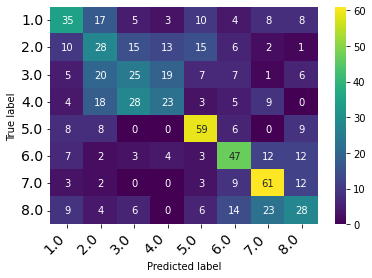

In [22]:
# logreg
logistic_cv((trainx, trainy), (testx, testy), class_names, 10)

The training acc Score is 0.7982142857142858
The testing acc Score is 0.4875
The testing acc Score STD 0.025078773973238388
              precision    recall  f1-score   support

         1.0       0.59      0.52      0.56        90
         2.0       0.45      0.47      0.46        90
         3.0       0.41      0.39      0.40        90
         4.0       0.49      0.59      0.54        90
         5.0       0.69      0.49      0.57        90
         6.0       0.46      0.56      0.51        90
         7.0       0.49      0.56      0.52        90
         8.0       0.38      0.33      0.35        90

    accuracy                           0.49       720
   macro avg       0.49      0.49      0.49       720
weighted avg       0.49      0.49      0.49       720



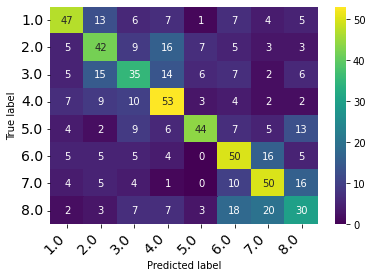

In [23]:
# dtree
dtree_cv((trainx, trainy), (testx, testy), class_names, 10)

The training acc Score is 0.7398809523809524
The testing acc Score is 0.6527777777777778
The testing acc Score STD 0.032853658389014606
              precision    recall  f1-score   support

         1.0       0.78      0.62      0.69        90
         2.0       0.54      0.67      0.60        90
         3.0       0.67      0.51      0.58        90
         4.0       0.68      0.68      0.68        90
         5.0       0.78      0.78      0.78        90
         6.0       0.68      0.72      0.70        90
         7.0       0.61      0.67      0.63        90
         8.0       0.56      0.58      0.57        90

    accuracy                           0.65       720
   macro avg       0.66      0.65      0.65       720
weighted avg       0.66      0.65      0.65       720



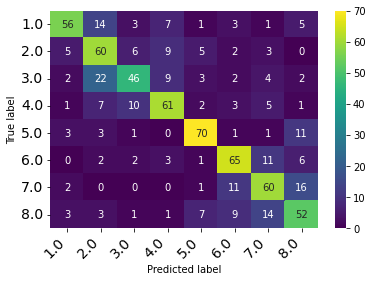

In [24]:
# svc
svc_cv((trainx, trainy), (testx, testy), class_names, 10)

The training acc Score is 0.768452380952381
The testing acc Score is 0.6583333333333333
The testing acc Score STD 0.03326532241220671
              precision    recall  f1-score   support

         1.0       0.76      0.77      0.76        90
         2.0       0.77      0.69      0.73        90
         3.0       0.69      0.56      0.62        90
         4.0       0.60      0.61      0.61        90
         5.0       0.74      0.74      0.74        90
         6.0       0.61      0.74      0.67        90
         7.0       0.67      0.54      0.60        90
         8.0       0.50      0.61      0.55        90

    accuracy                           0.66       720
   macro avg       0.67      0.66      0.66       720
weighted avg       0.67      0.66      0.66       720



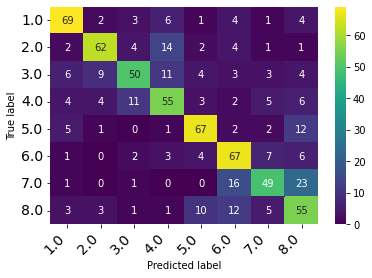

In [25]:
# knn
knn_cv((trainx, trainy), (testx, testy), class_names, 10)

The training acc Score is 0.9928571428571429
The testing acc Score is 0.6
The testing acc Score STD 0.020325441760671283
              precision    recall  f1-score   support

         1.0       0.59      0.68      0.63        90
         2.0       0.59      0.57      0.58        90
         3.0       0.63      0.60      0.61        90
         4.0       0.60      0.61      0.61        90
         5.0       0.67      0.68      0.67        90
         6.0       0.61      0.62      0.62        90
         7.0       0.59      0.60      0.60        90
         8.0       0.50      0.44      0.47        90

    accuracy                           0.60       720
   macro avg       0.60      0.60      0.60       720
weighted avg       0.60      0.60      0.60       720



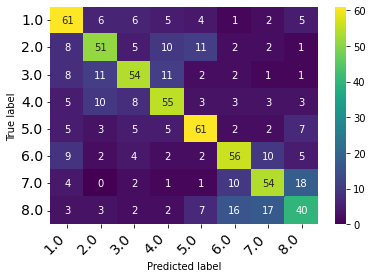

In [26]:
# rf
rf_cv((trainx, trainy), (testx, testy), class_names, 10)

The training acc Score is 0.33154761904761904
The testing acc Score is 0.3263888888888889
The testing acc Score STD 0.023615279077234968
              precision    recall  f1-score   support

         1.0       0.67      0.16      0.25        90
         2.0       0.19      0.13      0.16        90
         3.0       0.69      0.10      0.17        90
         4.0       0.34      0.49      0.40        90
         5.0       0.26      0.27      0.26        90
         6.0       0.38      0.44      0.41        90
         7.0       0.34      0.76      0.47        90
         8.0       0.26      0.27      0.26        90

    accuracy                           0.33       720
   macro avg       0.39      0.33      0.30       720
weighted avg       0.39      0.33      0.30       720



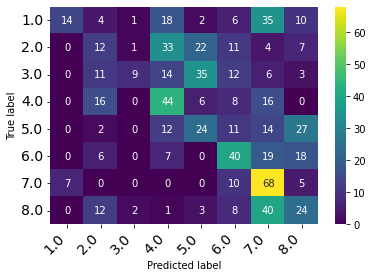

In [27]:
# nb
nb_cv((trainx, trainy), (testx, testy), class_names, 10)

The training acc Score is 0.8375
The testing acc Score is 0.5847222222222223
The testing acc Score STD 0.03186609241505755
              precision    recall  f1-score   support

         1.0       0.69      0.60      0.64        90
         2.0       0.56      0.54      0.55        90
         3.0       0.56      0.49      0.52        90
         4.0       0.64      0.60      0.62        90
         5.0       0.71      0.71      0.71        90
         6.0       0.57      0.64      0.61        90
         7.0       0.51      0.61      0.56        90
         8.0       0.46      0.48      0.47        90

    accuracy                           0.58       720
   macro avg       0.59      0.58      0.59       720
weighted avg       0.59      0.58      0.59       720



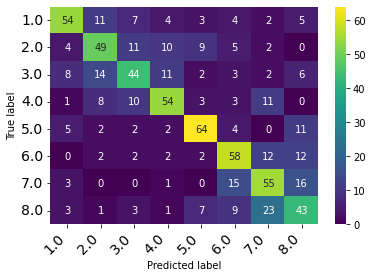

In [28]:
# xgb
xgb_cv((trainx, trainy), (testx, testy), class_names, 10)

#Time Duration Analysis

In [29]:
# Train Test Dataset
trainx, testx, trainy, testy = train_test_split(X,
                                                Y['Day'],
                                                test_size=0.3,
                                                random_state=42,
                                                stratify=Y['Day'])


# create class names
class_names = np.unique(Y['Day'])
class_names = [c for c in class_names]

The training acc Score is 0.7541666666666667
The testing acc Score is 0.7361111111111112
The testing acc Score STD 0.014734743325677832
              precision    recall  f1-score   support

         1.0       0.77      0.80      0.78       144
         4.0       0.64      0.68      0.66       144
         7.0       0.72      0.74      0.73       144
        10.0       0.80      0.75      0.77       144
        13.0       0.76      0.71      0.73       144

    accuracy                           0.74       720
   macro avg       0.74      0.74      0.74       720
weighted avg       0.74      0.74      0.74       720



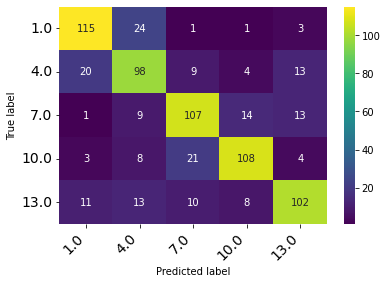

In [30]:
# logreg
logistic_cv((trainx, trainy), (testx, testy), class_names, 10)

The training acc Score is 0.8910714285714286
The testing acc Score is 0.7333333333333333
The testing acc Score STD 0.021980206519631635
              precision    recall  f1-score   support

         1.0       0.85      0.83      0.84       144
         4.0       0.66      0.73      0.69       144
         7.0       0.73      0.67      0.70       144
        10.0       0.75      0.78      0.76       144
        13.0       0.69      0.66      0.68       144

    accuracy                           0.73       720
   macro avg       0.73      0.73      0.73       720
weighted avg       0.73      0.73      0.73       720



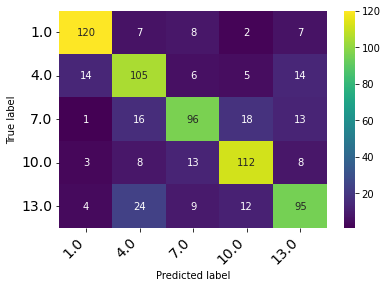

In [31]:
# dtree
dtree_cv((trainx, trainy), (testx, testy), class_names, 10)

The training acc Score is 0.9142857142857143
The testing acc Score is 0.8875
The testing acc Score STD 0.018906399691341554
              precision    recall  f1-score   support

         1.0       0.89      0.94      0.92       144
         4.0       0.84      0.85      0.85       144
         7.0       0.89      0.91      0.90       144
        10.0       0.92      0.90      0.91       144
        13.0       0.89      0.83      0.86       144

    accuracy                           0.89       720
   macro avg       0.89      0.89      0.89       720
weighted avg       0.89      0.89      0.89       720



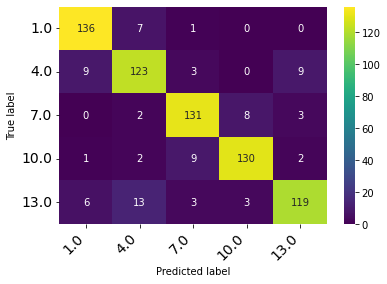

In [32]:
# svc
svc_cv((trainx, trainy), (testx, testy), class_names, 10)

The training acc Score is 0.9095238095238095
The testing acc Score is 0.8652777777777778
The testing acc Score STD 0.013693147737828286
              precision    recall  f1-score   support

         1.0       0.89      0.94      0.91       144
         4.0       0.76      0.85      0.80       144
         7.0       0.93      0.88      0.90       144
        10.0       0.89      0.90      0.90       144
        13.0       0.87      0.76      0.81       144

    accuracy                           0.87       720
   macro avg       0.87      0.87      0.87       720
weighted avg       0.87      0.87      0.87       720



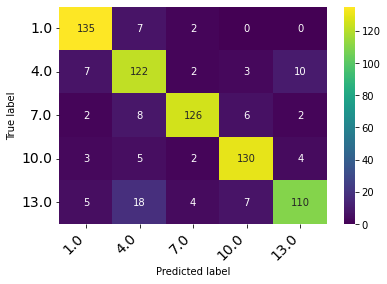

In [33]:
# knn
knn_cv((trainx, trainy), (testx, testy), class_names, 10)

The training acc Score is 0.9952380952380953
The testing acc Score is 0.825
The testing acc Score STD 0.020909723893155124
              precision    recall  f1-score   support

         1.0       0.82      0.91      0.86       144
         4.0       0.77      0.79      0.78       144
         7.0       0.84      0.85      0.85       144
        10.0       0.85      0.84      0.84       144
        13.0       0.85      0.73      0.78       144

    accuracy                           0.82       720
   macro avg       0.83      0.82      0.82       720
weighted avg       0.83      0.82      0.82       720



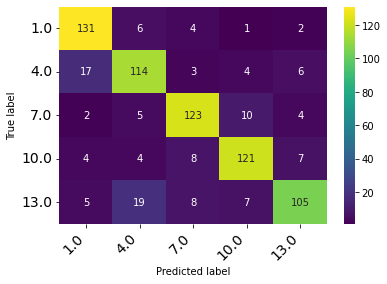

In [34]:
# rf
rf_cv((trainx, trainy), (testx, testy), class_names, 10)

The training acc Score is 0.3958333333333333
The testing acc Score is 0.4222222222222222
The testing acc Score STD 0.02000920989758525
              precision    recall  f1-score   support

         1.0       0.65      0.52      0.58       144
         4.0       0.28      0.08      0.12       144
         7.0       0.33      0.86      0.48       144
        10.0       0.47      0.11      0.18       144
        13.0       0.50      0.54      0.52       144

    accuracy                           0.42       720
   macro avg       0.45      0.42      0.38       720
weighted avg       0.45      0.42      0.38       720



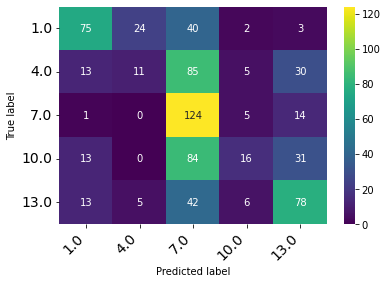

In [35]:
# nb
nb_cv((trainx, trainy), (testx, testy), class_names, 10)

The training acc Score is 0.9583333333333334
The testing acc Score is 0.8361111111111111
The testing acc Score STD 0.010240863413145949
              precision    recall  f1-score   support

         1.0       0.88      0.92      0.90       144
         4.0       0.82      0.75      0.78       144
         7.0       0.81      0.82      0.82       144
        10.0       0.86      0.88      0.87       144
        13.0       0.81      0.81      0.81       144

    accuracy                           0.84       720
   macro avg       0.84      0.84      0.84       720
weighted avg       0.84      0.84      0.84       720



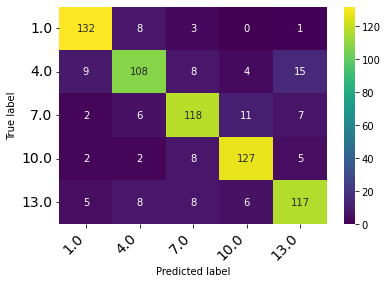

In [36]:
# xgb
xgb_cv((trainx, trainy), (testx, testy), class_names, 10)

#PCA Analysis

In [37]:

from sklearn.decomposition import PCA

pca = PCA(n_components=2)
pca_transformed_x = pca.fit_transform(X)
pca.explained_variance_ratio_

array([0.77590693, 0.12840131])

In [38]:
pca_df = pd.DataFrame(data=np.c_[pca_transformed_x, Y['Group']],
                       columns=['x1','x2', 'Group'])
pca_df.head()

,x1,x2,Group
0,-0.233189,-0.300880,1.0
1,-0.206821,-0.398972,1.0
2,-0.197120,-0.315957,1.0
3,-0.219207,-0.383198,1.0
4,-0.133099,-0.394987,1.0


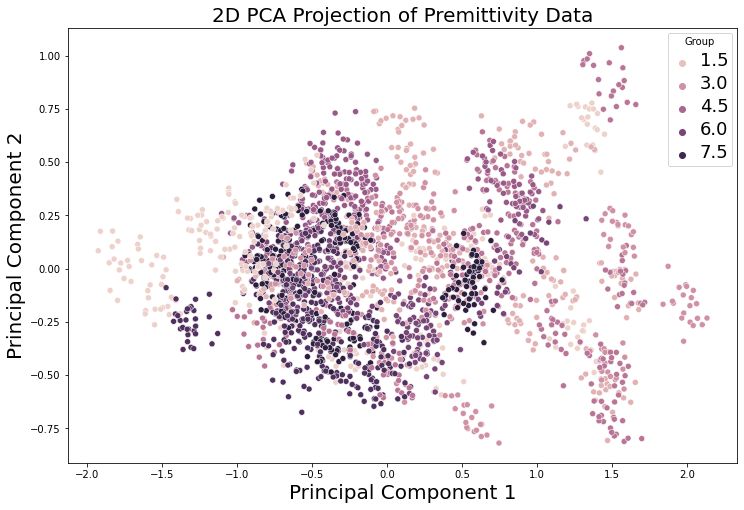

In [39]:

f, ax = plt.subplots(1,1, figsize=(12,8))
sns.scatterplot(data=pca_df, x='x1', y='x2', hue='Group', ax=ax)
ax.set_xlabel("Principal Component 1", fontsize=20)
ax.set_ylabel("Principal Component 2", fontsize=20)
ax.set_title("2D PCA Projection of Premittivity Data", fontsize=20)
plt.setp(ax.get_legend().get_texts(), fontsize='18'); # for legend text

#ANN-Group

In [41]:
import os
import sys
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
%matplotlib inline
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import Conv2D, Activation, Flatten, Dense
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import RMSprop, SGD, Adam
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import Input, BatchNormalization, Dropout
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.utils import plot_model
from tensorflow.keras import backend as K
from imutils import paths

In [42]:
X=df[['Average Zeroed Cap@174kHz', 'Average Zeroed Cap@224kHz', 'Average Zeroed Cap@287kHz', 'Average Zeroed Cap@368kHz', 'Average Zeroed Cap@473kHz', 'Average Zeroed Cap@607kHz', 'Average Zeroed Cap@779kHz', 'Average Zeroed Cap@1000kHz', 'Average Zeroed Cap@1284kHz', 'Average Zeroed Cap@1648kHz', 'Average Zeroed Cap@2115kHz']]
Y=df[['Group','Day']]

In [43]:
#Encoding the categorical Y
from sklearn.preprocessing import LabelBinarizer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
lb1=LabelBinarizer()
scaler=StandardScaler()
#Y=df[['Biomaterial','Time Period']]
X_transformed=scaler.fit_transform(X)
Y_transformed_group_ann = lb1.fit_transform(Y['Group'])

In [44]:
trainx, testx, trainy, testy = train_test_split(X_transformed,
                                                Y_transformed_group_ann,
                                                test_size=0.3,
                                                random_state=42)

In [45]:
# create the ANN model - time
model = Sequential()
model.add(Dense(units=16, input_shape=(X_transformed.shape[1],)))
model.add(Activation("relu"))
# model.add(Dense(units=16))
# model.add(Activation("relu"))
model.add(Dense(units=12))
model.add(Activation("relu"))
model.add(Dense(units=len(lb1.classes_)))
model.add(Activation("softmax"))
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 16)                192       
                                                                 
 activation (Activation)     (None, 16)                0         
                                                                 
 dense_1 (Dense)             (None, 12)                204       
                                                                 
 activation_1 (Activation)   (None, 12)                0         
                                                                 
 dense_2 (Dense)             (None, 8)                 104       
                                                                 
 activation_2 (Activation)   (None, 8)                 0         
                                                                 
Total params: 500
Trainable params: 500
Non-trainable pa

In [46]:
classes= np.unique(Y['Group'])
print(classes)

# create the ANN model - time
model = Sequential()
model.add(Dense(units=16, input_shape=(X.shape[1],)))
model.add(Activation("relu"))
# model.add(Dense(units=16))
# model.add(Activation("relu"))
model.add(Dense(units=12))
model.add(Activation("relu"))
model.add(Dense(units=len(classes)))
model.add(Activation("softmax"))
model.summary()

[1. 2. 3. 4. 5. 6. 7. 8.]
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_3 (Dense)             (None, 16)                192       
                                                                 
 activation_3 (Activation)   (None, 16)                0         
                                                                 
 dense_4 (Dense)             (None, 12)                204       
                                                                 
 activation_4 (Activation)   (None, 12)                0         
                                                                 
 dense_5 (Dense)             (None, 8)                 104       
                                                                 
 activation_5 (Activation)   (None, 8)                 0         
                                                                 
Total params: 500
Trainable 

In [47]:
# init some global variables
epochs = 1000
init_lr = 1e-3


# compile the model and start training
opt = Adam(learning_rate=init_lr, decay=init_lr/epochs)
model.compile(optimizer=opt,
              loss='categorical_crossentropy',
              metrics=['accuracy'])

H = model.fit(trainx, trainy,
              validation_data=(testx, testy),
              verbose=1,
              epochs=epochs)

Epoch 1/1000
53/53 [==============================] - 1s 8ms/step - loss: 2.1483 - accuracy: 0.0970 - val_loss: 2.0232 - val_accuracy: 0.1847
Epoch 2/1000
53/53 [==============================] - 0s 3ms/step - loss: 1.9695 - accuracy: 0.2512 - val_loss: 1.9195 - val_accuracy: 0.2681
Epoch 3/1000
53/53 [==============================] - 0s 3ms/step - loss: 1.8589 - accuracy: 0.2952 - val_loss: 1.8316 - val_accuracy: 0.2889
Epoch 4/1000
53/53 [==============================] - 0s 3ms/step - loss: 1.7798 - accuracy: 0.3280 - val_loss: 1.7790 - val_accuracy: 0.3222
Epoch 5/1000
53/53 [==============================] - 0s 3ms/step - loss: 1.7329 - accuracy: 0.3399 - val_loss: 1.7436 - val_accuracy: 0.3347
Epoch 6/1000
53/53 [==============================] - 0s 3ms/step - loss: 1.6980 - accuracy: 0.3577 - val_loss: 1.7160 - val_accuracy: 0.3375
Epoch 7/1000
53/53 [==============================] - 0s 3ms/step - loss: 1.6682 - accuracy: 0.3554 - val_loss: 1.6913 - val_accuracy: 0.3444
Epoch 

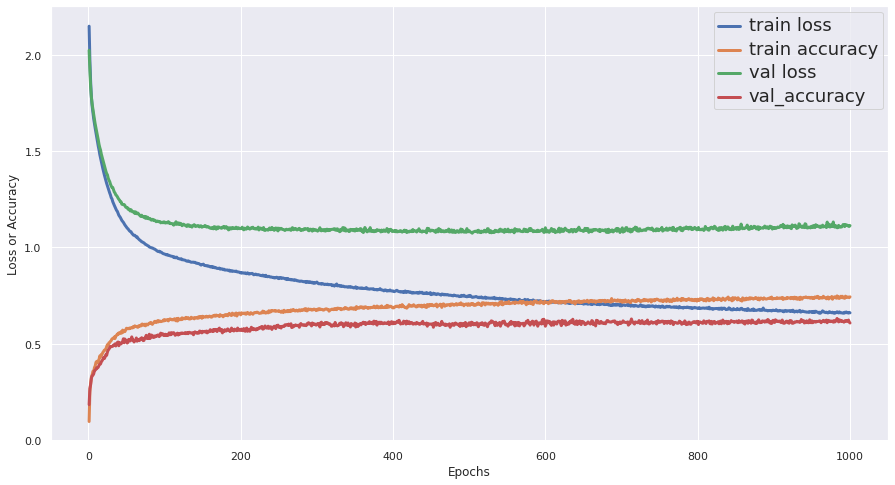

In [48]:
# plot the performance
epoch_num = range(1,epochs+1)
loss = H.history['loss']
accuracy = H.history['accuracy']
val_loss = H.history['val_loss']
val_accuracy = H.history['val_accuracy']
plot_df = pd.DataFrame(data=np.c_[epoch_num,
                                  loss,accuracy,
                                  val_loss,
                                  val_accuracy],
                       columns=['epochs','loss', 'accuracy', 'val_loss', 'val_accuracy'])

# do the actual plots
sns.set(font_scale=1)
f, ax = plt.subplots(1, 1, figsize=(15,8))
sns.lineplot(data=plot_df, x='epochs', y='loss', ax=ax, label='train loss', linewidth=3)
sns.lineplot(data=plot_df, x='epochs', y='accuracy', ax=ax, label='train accuracy', linewidth=3)
sns.lineplot(data=plot_df, x='epochs', y='val_loss', ax=ax, label='val loss', linewidth=3)
sns.lineplot(data=plot_df, x='epochs', y='val_accuracy', ax=ax, label='val_accuracy', linewidth=3)
ax.set_ylabel('Loss or Accuracy')
ax.set_xlabel('Epochs')
plt.setp(ax.get_legend().get_texts(), fontsize='18'); # for legend text

In [49]:
# calculate the classification report
from sklearn.metrics import classification_report
preds = model.predict(testx)
print(classification_report(testy.argmax(axis=1),
                            preds.argmax(axis=1)))

              precision    recall  f1-score   support

           0       0.66      0.65      0.66        92
           1       0.55      0.69      0.61        87
           2       0.58      0.54      0.56        87
           3       0.65      0.60      0.62        87
           4       0.75      0.64      0.69        95
           5       0.66      0.64      0.65        92
           6       0.51      0.73      0.60        79
           7       0.55      0.41      0.47       101

    accuracy                           0.61       720
   macro avg       0.61      0.61      0.61       720
weighted avg       0.62      0.61      0.61       720



#ANN-Day

In [50]:
lb2=LabelBinarizer()
scaler=StandardScaler()
X_transformed=scaler.fit_transform(X)
Y_transformed_day_ann = lb2.fit_transform(Y['Day'])

In [51]:
# split the dataset
trainx, testx, trainy, testy = train_test_split(X_transformed,
                                                Y_transformed_day_ann,
                                                test_size=0.3,
                                                random_state=42)

In [52]:
# create the ANN model - time
model = Sequential()
model.add(Dense(units=16, input_shape=(X_transformed.shape[1],)))
model.add(Activation("relu"))
# model.add(Dense(units=16))
# model.add(Activation("relu"))
model.add(Dense(units=12))
model.add(Activation("relu"))
model.add(Dense(units=len(lb2.classes_)))
model.add(Activation("softmax"))
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_6 (Dense)             (None, 16)                192       
                                                                 
 activation_6 (Activation)   (None, 16)                0         
                                                                 
 dense_7 (Dense)             (None, 12)                204       
                                                                 
 activation_7 (Activation)   (None, 12)                0         
                                                                 
 dense_8 (Dense)             (None, 5)                 65        
                                                                 
 activation_8 (Activation)   (None, 5)                 0         
                                                                 
Total params: 461
Trainable params: 461
Non-trainable 

In [53]:
# init some global variables
epochs = 1000
init_lr = 1e-3


# compile the model and start training
opt = Adam(learning_rate=init_lr, decay=init_lr/epochs)
model.compile(optimizer=opt,
              loss='categorical_crossentropy',
              metrics=['accuracy'])

H = model.fit(trainx, trainy,
              validation_data=(testx, testy),
              verbose=1,
              epochs=epochs)

Epoch 1/1000
53/53 [==============================] - 1s 6ms/step - loss: 1.5675 - accuracy: 0.2952 - val_loss: 1.4895 - val_accuracy: 0.3556
Epoch 2/1000
53/53 [==============================] - 0s 3ms/step - loss: 1.4626 - accuracy: 0.3893 - val_loss: 1.4060 - val_accuracy: 0.4417
Epoch 3/1000
53/53 [==============================] - 0s 3ms/step - loss: 1.3849 - accuracy: 0.4619 - val_loss: 1.3234 - val_accuracy: 0.5306
Epoch 4/1000
53/53 [==============================] - 0s 3ms/step - loss: 1.3031 - accuracy: 0.5387 - val_loss: 1.2347 - val_accuracy: 0.5583
Epoch 5/1000
53/53 [==============================] - 0s 3ms/step - loss: 1.2210 - accuracy: 0.5649 - val_loss: 1.1476 - val_accuracy: 0.6097
Epoch 6/1000
53/53 [==============================] - 0s 3ms/step - loss: 1.1436 - accuracy: 0.5923 - val_loss: 1.0716 - val_accuracy: 0.6278
Epoch 7/1000
53/53 [==============================] - 0s 3ms/step - loss: 1.0785 - accuracy: 0.6107 - val_loss: 1.0026 - val_accuracy: 0.6444
Epoch 

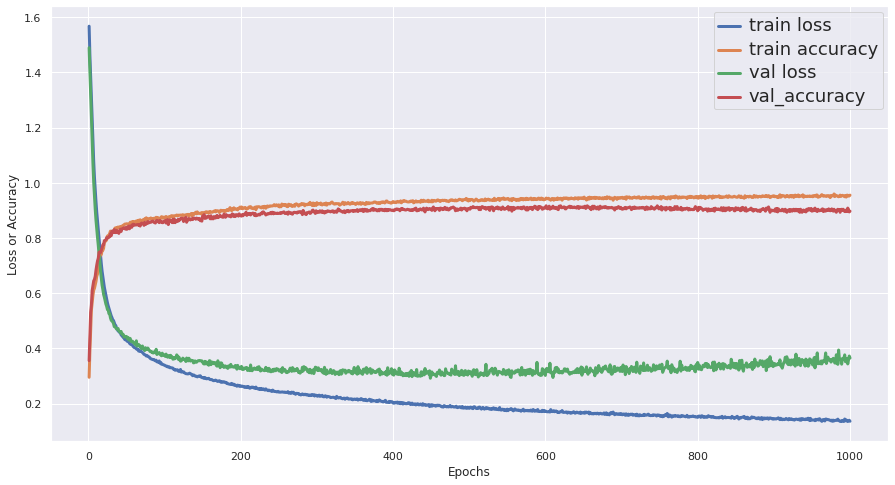

In [54]:
# plot the performance
epoch_num = range(1,epochs+1)
loss = H.history['loss']
accuracy = H.history['accuracy']
val_loss = H.history['val_loss']
val_accuracy = H.history['val_accuracy']
plot_df = pd.DataFrame(data=np.c_[epoch_num,
                                  loss,accuracy,
                                  val_loss,
                                  val_accuracy],
                       columns=['epochs','loss', 'accuracy', 'val_loss', 'val_accuracy'])

# do the actual plots
sns.set(font_scale=1)
f, ax = plt.subplots(1, 1, figsize=(15,8))
sns.lineplot(data=plot_df, x='epochs', y='loss', ax=ax, label='train loss', linewidth=3)
sns.lineplot(data=plot_df, x='epochs', y='accuracy', ax=ax, label='train accuracy', linewidth=3)
sns.lineplot(data=plot_df, x='epochs', y='val_loss', ax=ax, label='val loss', linewidth=3)
sns.lineplot(data=plot_df, x='epochs', y='val_accuracy', ax=ax, label='val_accuracy', linewidth=3)
ax.set_ylabel('Loss or Accuracy')
ax.set_xlabel('Epochs')
plt.setp(ax.get_legend().get_texts(), fontsize='18'); # for legend text

In [56]:
# calculate the classification report
from sklearn.metrics import classification_report
preds = model.predict(testx)
#print(classification_report(testy.argmax(axis=1), preds.argmax(axis=1), labels=class_names_day))
print(classification_report(testy.argmax(axis=1),
                            preds.argmax(axis=1)))

              precision    recall  f1-score   support

           0       0.96      0.97      0.96       156
           1       0.86      0.88      0.87       144
           2       0.91      0.91      0.91       142
           3       0.87      0.92      0.89       134
           4       0.89      0.81      0.84       144

    accuracy                           0.90       720
   macro avg       0.90      0.90      0.90       720
weighted avg       0.90      0.90      0.90       720

